In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import ndimage

In [2]:
def stretchFunc(x, alfa, Q, m):
    return np.arcsinh(alfa * Q * (x - m)) / Q

def createColorImage(filts, alfa=0.02, Q=6, m=0.0, maxRGB=None):
    filters = filts.copy()
    b = filters[:, :, 0]
    g = filters[:, :, 1]
    r = filters[:, :, 2]
    b *= 2.1
    g *= 1.2
    b[b < 0.0] = 0.0
    g[g < 0.0] = 0.0
    r[r < 0.0] = 0.0
    I = (b + g + r) / 3.0
    idxOfNonZeros = np.abs(I) > 1e-12
    factor = np.full(b.shape, 1.0)
    factor[idxOfNonZeros] = stretchFunc(I[idxOfNonZeros], alfa, Q, m) / I[idxOfNonZeros]

    B = b * factor
    G = g * factor
    R = r * factor

    if maxRGB is None:
        maxRGB = np.max([np.max(R), np.max(G), np.max(B)])
    R = R / maxRGB
    G = G / maxRGB
    B = B / maxRGB
    R[I < 1e-12] = 0.0
    G[I < 1e-12] = 0.0
    B[I < 1e-12] = 0.0

    shp = (b.shape[0], b.shape[1], 3)
    rgb = np.empty(shp)
    rgb[:, :, 0] = R
    rgb[:, :, 1] = G
    rgb[:, :, 2] = B
    return rgb, maxRGB

def plotMask(rgb, mask, rgb_code=[1,0,0]):
    rgbTemp = np.copy(rgb)
    mm = ndimage.binary_erosion(mask)
    outline = np.logical_and(mask, np.logical_not(mm))
    rgbTemp[outline == 1,0] = rgb_code[0]
    rgbTemp[outline == 1,1] = rgb_code[1]
    rgbTemp[outline == 1,2] = rgb_code[2]
    
    return rgbTemp

def cartesianToSpherical(x):
    N = x.shape[1]
    # rfi = [r, fi1, fi2, ..., fiN-1]
    rfi = np.empty(x.shape)
    rfi[:,0] = np.sqrt( np.sum( x**2, axis=1 ) )
    for i in range(1,N-1):        
        rfi[:, i] = np.arccos( x[:, i-1]/np.sqrt(np.sum(x[:, i-1:N] ** 2, axis=1)) )        
    condition = np.less( x[:, N-1], 0.0 )
    rfi[:, N-1] = np.where( condition, 
                2*np.pi - np.arccos( x[:, N - 2] / np.sqrt( x[:, N - 1]**2 + x[:, N - 2]**2 ) ),
                np.arccos( x[:, N - 2] / np.sqrt( x[:, N - 1]**2 + x[:, N - 2]**2 ) ))
    
    return rfi

# spherical to cartesian in N dimensions
def sphericalToCartesian(rfi):
    N = rfi.shape[1]
    x = np.empty(rfi.shape)
    x[:,0] = rfi[:,0] * np.cos(rfi[:,1])
    x[:, N - 1] = rfi[:, 0] * np.prod(np.sin(rfi[:, 1:N]), axis=1)
    for i in range(1,N-1):
        x[:,i] = rfi[:,0] * np.prod( np.sin( rfi[:, 1:i+1] ), axis=1 ) * np.cos( rfi[:,i+1] )
    return x

## Reading the dataset

In [3]:
workdir = "data/"

In [4]:
train_set = np.load( workdir + "train_set.npy" )
test_set = np.load( workdir + "test_set.npy" )
val_set = np.load( workdir + "val_set.npy" )
train_set_labels = np.load( workdir + "train_set_labels.npy" )
test_set_labels = np.load( workdir + "test_set_labels.npy" )
val_set_labels = np.load( workdir + "val_set_labels.npy" )

train_set_df = pd.read_csv( workdir + "train_set.csv" )
test_set_df = pd.read_csv( workdir + "test_set.csv" )
val_set_df = pd.read_csv( workdir + "val_set.csv" )

all_data_df = pd.read_csv( workdir + "all_data.csv" )

In [5]:
test_set_df.columns

Index(['index', 'Unnamed: 0', 'galaxyID', 'redshift', 'lum_disk_g_abs',
       'lum_disk_r_abs', 'lum_disk_i_abs', 'lum_disk_z_abs', 'lum_bulge_g_abs',
       'lum_bulge_r_abs', 'lum_bulge_i_abs', 'lum_bulge_z_abs', 'lum_disk_g',
       'lum_disk_r', 'lum_disk_i', 'lum_disk_z', 'lum_bulge_g', 'lum_bulge_r',
       'lum_bulge_i', 'lum_bulge_z', 'mag_g', 'mag_r', 'mag_i', 'mag_z',
       'lum_g_abs', 'lum_r_abs', 'lum_i_abs', 'lum_z_abs', 'mag_g_', 'mag_r_',
       'mag_i_', 'mag_z_', 'mag_bulge_g', 'mag_bulge_r', 'mag_bulge_i',
       'mag_bulge_z', 'mag_disk_g', 'mag_disk_r', 'mag_disk_i', 'mag_disk_z',
       'adu_bulge_g', 'adu_bulge_r', 'adu_bulge_i', 'adu_bulge_z',
       'adu_disk_g', 'adu_disk_r', 'adu_disk_i', 'adu_disk_z', 'hlr_disk',
       'hlr_bulge', 'sersic_disk', 'sersic_bulge', 'axisratio_disk',
       'axisratio_bulge', 'beta', 'lum_bulge', 'lum_disk', 'bt_flux_ratio',
       'bd_flux_ratio', 'sed_bulge_orig_g', 'sed_bulge_orig_r',
       'sed_bulge_orig_i', 'sed_bulge_

## Plot the distribution of the dataset

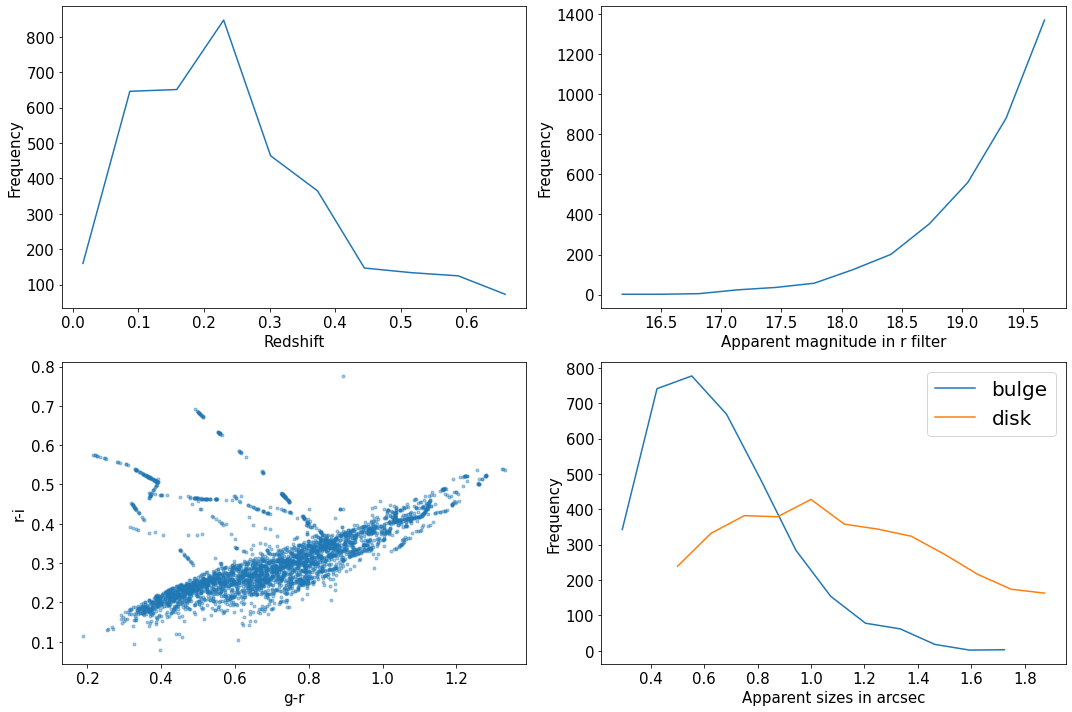

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(15,10))

fs = 20
ts = 15

hist = np.histogram( all_data_df["redshift"], bins=10 )
axs[0, 0].plot( hist[1][:-1], hist[0] )
axs[0, 0].tick_params(axis='both', labelsize=ts)
axs[0, 0].set_xlabel( "Redshift", fontsize=ts )
axs[0, 0].set_ylabel( "Frequency", fontsize=ts )

hist = np.histogram( all_data_df["mag_r"], bins=12 )
axs[0, 1].plot( hist[1][:-1], hist[0] )
axs[0, 1].tick_params(axis='both', labelsize=ts)
axs[0, 1].set_xlabel( "Apparent magnitude in r filter", fontsize=ts )
axs[0, 1].set_ylabel( "Frequency", fontsize=ts )

g_r = all_data_df["mag_g"] - all_data_df["mag_r"]
r_i = all_data_df["mag_r"] - all_data_df["mag_i"]
axs[1, 0].plot( g_r, r_i, ".", alpha=0.4 )
axs[1, 0].tick_params(axis='both', labelsize=ts)
axs[1, 0].set_xlabel( "g-r", fontsize=ts )
axs[1, 0].set_ylabel( "r-i", fontsize=ts )

hist1 = np.histogram( all_data_df["hlr_bulge"], bins=12 )
hist2 = np.histogram( all_data_df["hlr_disk"], bins=12 )
axs[1, 1].plot( hist1[1][:-1], hist1[0], label="bulge" )
axs[1, 1].plot( hist2[1][:-1], hist2[0], label="disk" )
axs[1, 1].legend(fontsize=fs)
axs[1, 1].tick_params(axis='both', labelsize=ts)
axs[1, 1].set_xlabel( "Apparent sizes in arcsec", fontsize=ts )
axs[1, 1].set_ylabel( "Frequency", fontsize=ts )

plt.tight_layout()


In [7]:
# flatten the color histograms for sedNN
train_set_flat = train_set.reshape( (train_set.shape[0], train_set.shape[1]*train_set.shape[2]) )
val_set_flat = val_set.reshape( (val_set.shape[0], val_set.shape[1]*val_set.shape[2]) )
test_set_flat = test_set.reshape( (test_set.shape[0], test_set.shape[1]*test_set.shape[2]) )

In [8]:
print( train_set_flat.shape )
print( val_set_flat.shape )
print( test_set_flat.shape )


(2369, 540)
(539, 540)
(704, 540)


# define the model

In [9]:
# this is a callback class for saving the model weights when the error is minimal on the validation set
class save_best_weights( tf.keras.callbacks.Callback ):
    def __init__(self):
        super(save_best_weights, self).__init__()
        self.best_weights = None
        self.best = np.Inf
    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if np.less(current_loss, self.best):
            self.best = current_loss
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch
            print('\nSaving weights, loss= {0:6.4f} \n'.format(current_loss))

In [10]:
class Model(keras.Model):
    def __init__(self, **kwargs):
        super(Model, self).__init__(**kwargs)
        inputs = keras.Input(shape=180*3)
        x = layers.Dense(120, activation="elu")(inputs)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(120, activation="elu")(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Dense(120, activation="elu")(x)
        x = layers.Dropout(0.2)(x)
        x = layers.Flatten()(x)
        
        seds = layers.Dense(6, activation="elu")(x)
        sedBulgeLast = 1.0 - tf.math.reduce_sum(seds[...,:3], axis=1 )
        sedDiskLast = 1.0 - tf.math.reduce_sum(seds[...,3:], axis=1 )
        sedBulge = tf.concat([seds[...,:3], tf.expand_dims(sedBulgeLast, axis=-1 )], axis=-1)
        sedDisk = tf.concat([seds[...,3:], tf.expand_dims(sedDiskLast, axis=-1 )], axis=-1)
        seds = tf.concat([sedBulge, sedDisk], axis=-1)
        self.m = keras.Model( inputs, seds, name="model" )
        
    def call(self, inputs):
        return self.m(inputs)
        
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)
          
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

## Training the model

In [11]:
model = Model()
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=opt,
    loss="MeanSquaredError"
)

In [12]:
save_best_weights_cb = save_best_weights()

In [ ]:
"""
history = model.fit(
    x = train_set_flat,
    y = train_set_labels,
    shuffle = True,
    epochs=20000,
    batch_size=128,
    validation_data = (
        val_set_flat,
        val_set_labels
    ),
    callbacks = [
        save_best_weights_cb
    ]

)
"""

In [ ]:
#model.set_weights( save_best_weights_cb.best_weights )

### Load the model

In [13]:
model = keras.models.load_model( "sedNN" )

## Evaluate the model on test set

In [14]:
model.evaluate(
    x = test_set_flat,
    y = test_set_labels
)

22/22 [==============================] - 0s 2ms/step - loss: 2.1696e-04


0.00021696351177524775

### Read the example galaxy

In [15]:
galdir = "data/example_galaxy/"

In [16]:
galID = "1437579805"
cube = np.load( galdir + galID + ".npy" )
msk = np.load( galdir + galID + "_mask.npy" )
rgb = createColorImage(cube, alfa=0.02, Q=6, m=0.0, maxRGB=None)[0]

### Plot the galaxy false color image with its mask

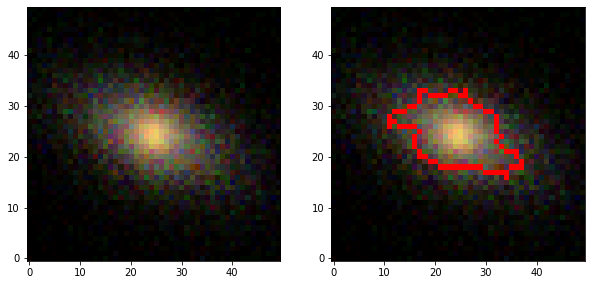

In [17]:
plt.figure(figsize=(10,7))

plt.subplot(1,2,1)
plt.imshow( rgb, origin="lower" )
plt.subplot(1,2,2)
plt.imshow( plotMask( rgb, msk ), origin="lower" )

### Calculate the color histogram which is the input of sedNN

In [18]:
numOfBins = 180
cube_flat = cube.reshape( (cube.shape[0]*cube.shape[1], cube.shape[2]) )
sph_flat = cartesianToSpherical( cube_flat )
cuben = sph_flat.reshape( cube.shape )[...,1:]
    
hist0 = np.histogram( cuben[msk,0], bins=numOfBins, range=[0,np.pi/2] )
hist1 = np.histogram( cuben[msk,1], bins=numOfBins, range=[0,np.pi/2] )
hist2 = np.histogram( cuben[msk,2], bins=numOfBins, range=[0,np.pi/2] )
        
mtx = np.empty((3,numOfBins))
mtx[0,:] = hist0[0]
mtx[1,:] = hist1[0]
mtx[2,:] = hist2[0]
mtx /= mtx.max()

C:\Users\kunsagi\AppData\Local\Temp/ipykernel_21032/353639890.py:55: RuntimeWarning: invalid value encountered in true_divide
  rfi[:, i] = np.arccos( x[:, i-1]/np.sqrt(np.sum(x[:, i-1:N] ** 2, axis=1)) )
C:\Users\kunsagi\AppData\Local\Temp/ipykernel_21032/353639890.py:58: RuntimeWarning: invalid value encountered in true_divide
  2*np.pi - np.arccos( x[:, N - 2] / np.sqrt( x[:, N - 1]**2 + x[:, N - 2]**2 ) ),
C:\Users\kunsagi\AppData\Local\Temp/ipykernel_21032/353639890.py:59: RuntimeWarning: invalid value encountered in true_divide
  np.arccos( x[:, N - 2] / np.sqrt( x[:, N - 1]**2 + x[:, N - 2]**2 ) ))


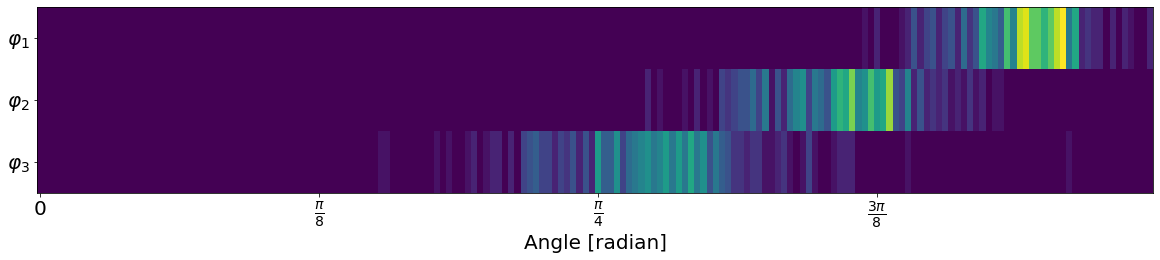

In [19]:
plt.figure(figsize=(20,20))
fs = 20
plt.xticks(fontsize=fs)
plt.xlabel("Angle [radian]", fontsize=fs)

plt.xticks(ticks=[0, 45, 90, 135, 180], labels=['0', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$'], fontsize=fs)
plt.yticks(ticks=[0, 1, 2], labels=[r'$\varphi_1$',r'$\varphi_2$', r'$\varphi_3$'], fontsize=fs)

plt.imshow(mtx, aspect=10.0)

In [21]:
idx = test_set_df[ test_set_df["galaxyID"] == int(galID) ].index[0]

In [22]:
sample = np.expand_dims(mtx.T.flatten(), axis=0)
gt = test_set_labels[idx,...].flatten()
pred = model(sample).numpy().flatten()

## Compare the results with SCARLET

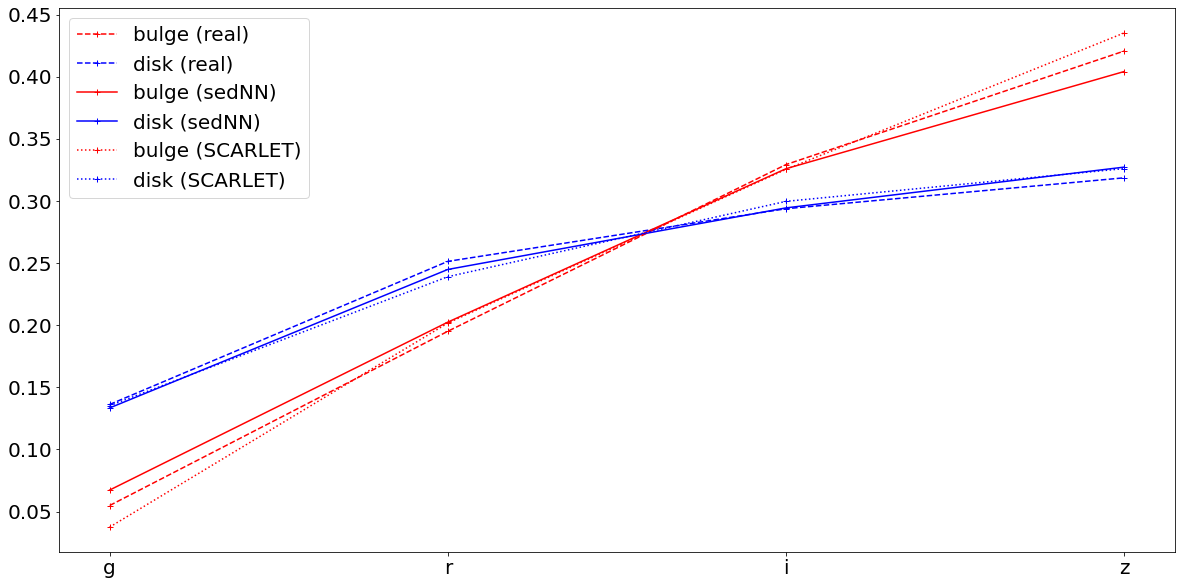

In [23]:
gt = test_set_labels[idx,...].flatten()
scarlet_pred = test_set_df.iloc[idx][["sed_bulge_scarlet_g","sed_bulge_scarlet_r","sed_bulge_scarlet_i","sed_bulge_scarlet_z",
                            "sed_disk_scarlet_g","sed_disk_scarlet_r","sed_disk_scarlet_i","sed_disk_scarlet_z"]].values

filters = ["g","r","i","z"]

fs = 20

plt.figure(figsize=(20,10))
plt.plot( filters, gt[:4], "+--", c="red", label="bulge (real)" )
plt.plot( filters, gt[4:], "+--", c="blue", label="disk (real)" )
plt.plot( filters, pred[:4], "+-", c="red", label="bulge (sedNN)" )
plt.plot( filters, pred[4:], "+-", c="blue", label="disk (sedNN)" )
plt.plot( filters, scarlet_pred[:4], "+:", c="red", label="bulge (SCARLET)" )
plt.plot( filters, scarlet_pred[4:], "+:", c="blue", label="disk (SCARLET)" )
plt.xticks( fontsize=fs )
plt.yticks( fontsize=fs )
plt.legend(fontsize=fs)